# **Fem Basis 2**

# Introduction to 2D Finite Element Method (FEM) with Linear (P1) Basis Functions

In this notebook, we explore the **Finite Element Method (FEM)** in 2D using **triangular elements** and **linear (P1) basis functions**.  

The goal is to understand the **basic building blocks**: **nodes, triangles, and basis functions**, before we dive into code.

---

## 1. Nodes, Edges, and Triangles

- A **node** is a point in 2D space where we define unknowns (e.g., temperature, displacement):

$ \mathbf{x}_i = (x_i, y_i) $

- An **edge** connects two nodes.  

- A **triangle (finite element)** is defined by three nodes:

$ \mathbf{x}_1 = (x_1, y_1), \quad
\mathbf{x}_2 = (x_2, y_2), \quad
\mathbf{x}_3 = (x_3, y_3) $

- The triangle consists of all points $(x, y)$ that can be written as a **linear combination of its vertices with non-negative weights summing to 1**:

$$
T = \left\{ (x, y) \in \mathbb{R}^2 \ \bigg| \ (x, y) = \lambda_1 \mathbf{x}_1 + \lambda_2 \mathbf{x}_2 + \lambda_3 \mathbf{x}_3, \ \lambda_1, \lambda_2, \lambda_3 \ge 0, \ \lambda_1 + \lambda_2 + \lambda_3 = 1 \right\}
$$

Here, $\lambda_1, \lambda_2, \lambda_3$ are called **barycentric coordinates**, which are key for defining linear basis functions.

---

## 2. Basis Functions (P1 / Linear)

For each node $i$, we define a **basis function** $\phi_i(x, y)$ with the following properties:

$$
\phi_i(\mathbf{x}_j) =
\begin{cases}
1 & \text{if } j = i \\
0 & \text{if } j \neq i
\end{cases}
$$

- $\phi_i(x, y)$ is **piecewise linear** over each triangle.  
- Its **support** is all triangles that contain node $i$.  

**Intuition:**  

- Think of $\phi_i$ as a **small "tent"** over the node $i$.  
- It is **1 at its node** and **tapers linearly to 0 at neighboring nodes**.  
- Only the triangles touching node $i$ contribute to $\phi_i$.  

---

## 3. Node-Triangle Relationship

- Each node belongs to multiple triangles.  
- If node $i$ is connected to triangles $T_1, T_2, ..., T_k$, then the **basis function $\phi_i$ is nonzero only on these triangles**.  
- This is why P1 basis functions are **locally supported**: changing the value at one node only affects nearby triangles.

---

## 4. Approximating a Solution with Basis Functions

The FEM solution is expressed as a **linear combination of basis functions**:

$$
u(x, y) \approx \sum_{i=1}^{N} u_i \, \phi_i(x, y)
$$

- $u_i$ are the unknown values at the nodes.  
- $N$ is the total number of nodes.  
- Each $\phi_i(x, y)$ contributes only on its supporting triangles.  

This is the **core idea of FEM**: we approximate a complex solution using simple, local, piecewise-linear functions.

---

## 5. Summary of Key Concepts

| Concept | Description |
|---------|-------------|
| Node ($\mathbf{x}_i$) | A point where the solution is defined |
| Edge | Connects two nodes |
| Triangle | Finite element formed by three nodes |
| Basis function ($\phi_i$) | Linear function, 1 at node $i$, 0 at all other nodes, nonzero only on triangles touching node $i$ |


So, in this approach, we fix the number of basis functions. This automatically means that the number of nodes is fixed, since each basis function is associated with exactly one node where it is nonzero.
For simplicity, we choose a square number of basis functions, because we generate the nodes on a uniform square grid.

We also take triangles of the same size (finite elements). Makes sense because we have same amount of datat points for every (x,y)

By fixing a square number of basis functions and generating a grid of uniform triangles, we create a structured mesh.
Note that not every node must correspond exactly to a data point, which is actually beneficial in many cases.
Like for Example i our case I considered a 20x20 longitude, latitude grid. this means I have 400 nodes (which would correspond to 400 basis fucntions if I make a basis for every node). So in this code we fix the amount of Basis functions we want and then create a uniform mesh over it meaning not every node hits a (x,y) where we have data.



In [ ]:
import numpy as np
from scipy.spatial import Delaunay

class FEMBasis2D:
    """
    FEM P1 basis (meaning linear hat functions, we can still change for more smoothness later) for 2D triangular mesh, with support for generating
    a reduced number of basis nodes (e.g., uniform grid).
    """

    def __init__(self, nodes, triangles):
        self.nodes = np.array(nodes)        # (N_nodes, 2 -> (x,y))
        self.triangles = np.array(triangles)  # (N_triangles, 3 -> (which 3 vertice))
        self.tri_engine = Delaunay(self.nodes)  # for fast lookup tri_engine: a Delaunay object built on nodes to quickly find: Which triangle contains a given point (find_simplex).

    @classmethod



    def from_domain(cls, domain, K, exact=False):
        """
        makes a unifrom gris with the K amount of nodes we want to have

        K = amount of basis we want to have, corresponding to the amount of nodes
        Generate K (approximately) basis nodes uniformly over the domain.
        domain = ((xmin, ymin), (xmax, ymax))
        """
        (xmin, ymin), (xmax, ymax) = domain

        # Choose grid resolution (≈ square)
        nx = int(np.floor(np.sqrt(K)))
        ny = int(np.ceil(K / nx))


        #creates grid
        xs = np.linspace(xmin, xmax, nx)
        ys = np.linspace(ymin, ymax, ny)
        X, Y = np.meshgrid(xs, ys)
        nodes = np.vstack([X.ravel(), Y.ravel()]).T # node and coordinate


        if exact and len(nodes) > K:
            nodes = nodes[:K]  # trim to exactly K basis nodes

        #Uses Delaunay triangulation to create triangles from the nodes.
        triangles = Delaunay(nodes).simplices
        return cls(nodes, triangles)

    @staticmethod
    '''
    Basically just calculates the slope/gradient
    '''
    def _barycentric_coords(point, tri_nodes):
        x, y = point
        x1, y1 = tri_nodes[0]
        x2, y2 = tri_nodes[1]
        x3, y3 = tri_nodes[2]

        detT = (y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3)
        if abs(detT) < 1e-12:
            return None

        l1 = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / detT
        l2 = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / detT
        l3 = 1 - l1 - l2
        return np.array([l1, l2, l3])

    def evaluate_basis(self, points):
        """
        Returns Φ (n_points × n_basis)
        """
        points = np.array(points)
        Φ = np.zeros((len(points), len(self.nodes)))

        simplex_idx = self.tri_engine.find_simplex(points)

        for i, point in enumerate(points):
            s = simplex_idx[i]
            if s == -1:
                continue  # outside domain

            tri = self.triangles[s]
            tri_nodes = self.nodes[tri]
            bary = self._barycentric_coords(point, tri_nodes)

            if bary is not None and np.all(bary >= -1e-12):
                Φ[i, tri] = bary

        return Φ

    def __len__(self):
        return len(self.nodes)


# **Example 1 easy**

okay now a very easy example of a code: just one square just so you can see how a basis should look like


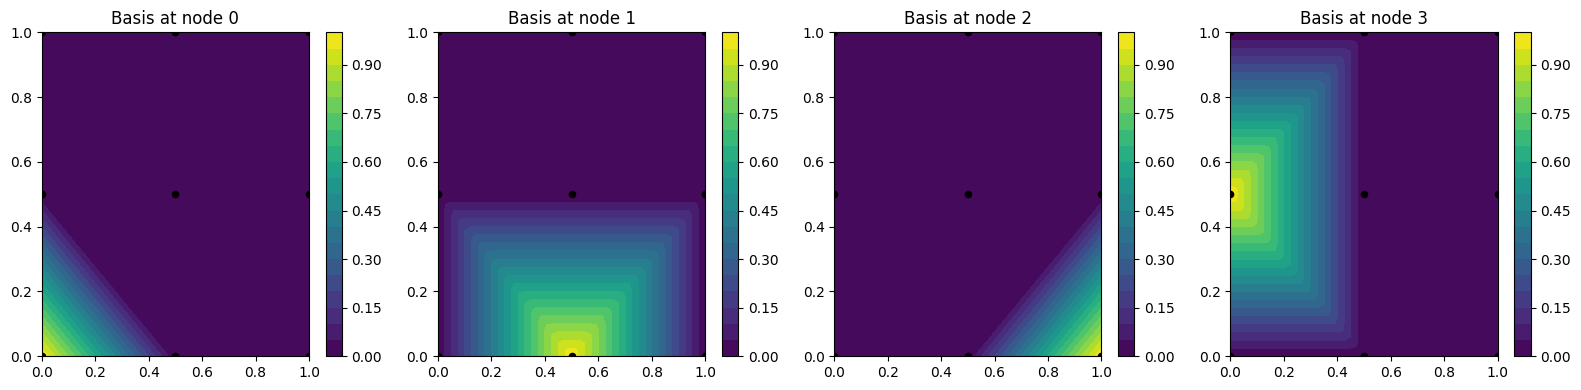

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create FEMBasis2D instance using K ---
domain = ((0, 0), (1, 1))
K = 9  # number of basis nodes
fem = FEMBasis2D.from_domain(domain, K)

# --- Create grid of evaluation points ---
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

# --- Evaluate basis functions at grid points ---
phi = fem.evaluate_basis(points)

# --- Plot first 4 basis functions (or fewer if less nodes) ---
num_plots = min(4, len(fem))  # first 4 nodes
fig, axes = plt.subplots(1, num_plots, figsize=(4*num_plots, 4))

if num_plots == 1:
    axes = [axes]

for i in range(num_plots):
    Z = phi[:, i].reshape(X.shape)
    ax = axes[i]
    c = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(fem.nodes[:, 0], fem.nodes[:, 1], c='k', s=20)  # show basis nodes
    ax.set_title(f'Basis at node {i}')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


# **The Data I want to consider**

the data i would like to consider is just 20x20 data points which give us 400 nodes where we each have 25 years of temperature values.
You can see in the plot below.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive
drive.mount('/content/drive')

# Read CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/Bayesiean/FEM/square_20x20_25years.csv"
df = pd.read_csv(csv_path)

print(df.head())

Mounted at /content/drive
   lat  lon  year   mean
0   33    2  1983  18.38
1   33    2  1984  17.17
2   33    2  1985  18.08
3   33    2  1986  17.52
4   33    2  1987  18.69


/tmp/ipython-input-3483646291.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(lat_labels)
/tmp/ipython-input-3483646291.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(lon_labels)


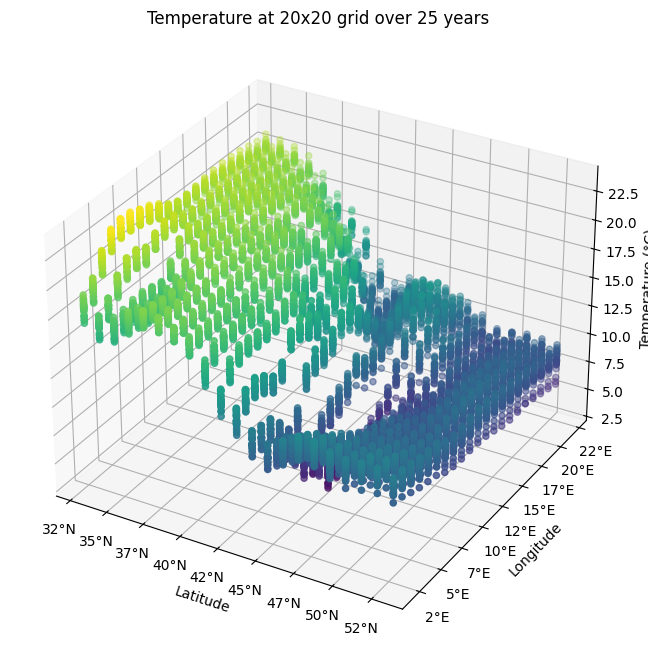

In [17]:
import matplotlib.ticker as mticker

# Scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# x = latitude, y = longitude, z = temperature
sc = ax.scatter(df['lat'], df['lon'], df['mean'], c=df['mean'], cmap='viridis', s=20)

# Axis labels
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Temperature (°C)')
ax.set_title('Temperature at 20x20 grid over 25 years')

# Format latitude ticks with N/S
lat_ticks = ax.get_xticks()
lat_labels = [f"{abs(int(tick))}°{'N' if tick >=0 else 'S'}" for tick in lat_ticks]
ax.set_xticklabels(lat_labels)

# Format longitude ticks with E/W
lon_ticks = ax.get_yticks()
lon_labels = [f"{abs(int(tick))}°{'E' if tick >=0 else 'W'}" for tick in lon_ticks]
ax.set_yticklabels(lon_labels)

plt.show()

# **Example 2 - for our data**

Now we want to make a basis function for our data. dor 20x20 = 400 basis functions would be too much. so we would now a squred number that gives us less basisi functions. lets choose 100 for now.

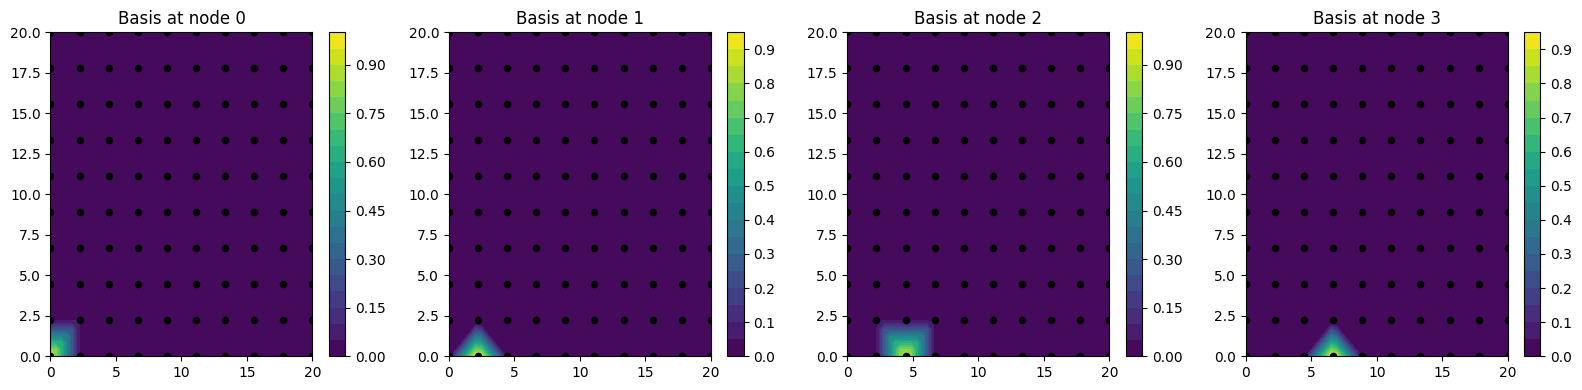

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create FEMBasis2D instance using K ---
domain = ((0, 0), (20, 20))
K = 100  # number of basis nodes (approx.)
fem = FEMBasis2D.from_domain(domain, K)

# --- Automatically determine evaluation grid over the mesh ---
xmin, ymin = np.min(fem.nodes, axis=0)
xmax, ymax = np.max(fem.nodes, axis=0)

nx, ny = 50, 50  # resolution of grid for plotting
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

# --- Evaluate basis functions at grid points ---
phi = fem.evaluate_basis(points)

# --- Plot first 4 basis functions (or fewer if less nodes) ---
num_plots = min(4, len(fem))  # first 4 nodes
fig, axes = plt.subplots(1, num_plots, figsize=(4*num_plots, 4))

if num_plots == 1:
    axes = [axes]

for i in range(num_plots):
    Z = phi[:, i].reshape(X.shape)
    ax = axes[i]
    c = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(fem.nodes[:, 0], fem.nodes[:, 1], c='k', s=20)  # show basis nodes
    ax.set_title(f'Basis at node {i}')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()
